# Initializing z with image instead of random codes

This notebook shows how to start witb image instead of random initilization.

In [8]:
import sys
sys.path.append("../")

# Workaround problems with downloading some models from pytorch hub.
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import os
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torch import nn, optim
from synth.synth import *
from synth.agumenter import Agumenter
from synth.objective import ObjectiveCLIP, SimplePrompt

## Loading models

In [2]:
device = torch.device("cuda:0")
#device = torch.device("cpu") # CPU

m_file = lambda file: os.path.join(os.getenv("MODEL_STORE"), file)
CLIP_MODEL_FILEPATH = m_file("ViT-B-32.pt")
VQGAN_CONFIG_FILEPATH = m_file("sflckr.yaml")
VQGAN_CHECKPOINT_FILEPATH = m_file("sflckr.ckpt")
VQGAN_MODEL_TYPE = "conditional"

model_clip, clip_preprocessor = load_clip(CLIP_MODEL_FILEPATH, device)
model_vqgan = load_vqgan(VQGAN_CHECKPOINT_FILEPATH,
                         VQGAN_CONFIG_FILEPATH,
                         device,
                         model_type=VQGAN_MODEL_TYPE)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from /workspace/weights/sflckr.ckpt


## Hyperprameters and objecive

In [3]:
TARGET_IMAGE_SIZE = 960
LR = 0.05
N_ITER = 100
CUTN = 50

PROMPTS = [{"prompt": "Mountain panorama covered in snow.", "weight": 0.3},
           {"prompt": "Snow", "weight": 1.0},
           {"prompt": "Clouds", "weight": 0.1},
           {"prompt": "DLSR panorama", "weight": 1.0}]

prompts = SimplePrompt.make_text_prompts(PROMPTS, model_clip, device)
objective = ObjectiveCLIP(prompts, Agumenter(device, CUTN), model_clip, device)

## Initialize Z from image file

We load image from file and if necessary we resize it to the desired size of the output from VQGAN. Then we convert it to tensor, unsqueeze and we process it so it spans between -1 and 1 instead of between 0 and 1.
Then we encode it using VQGAN encoder stage to get Z tensor. CLIP cannot accept non square images so we will enforce that images passed to initialization function are also non square in order to avoid unneessary sdistortions
during resize process.

In [4]:
def z_from_image(img, img_size, model_vqgan, device):
    if isinstance(img, str):
        img = Image.open(img)
    
    assert img.size[0] == img.size[1]
    
    if img.size[0] != img_size:
        img = img.resize((img_size, img_size))
    Agumenter(device, CUTN)
    img = torch.unsqueeze(ToTensor()(img), 0).to(device)
    img = 2.0*img - 1.0
    
    return model_vqgan.encode(img)[0]

z = z_from_image("samples/mountains.jpg", TARGET_IMAGE_SIZE, model_vqgan, device)
z.requires_grad_(True)
opt = optim.Adam([z], lr=LR)

## Run synthesis

In [5]:
filepath = run(opt, z, objective, model_vqgan, model_clip, N_ITER, save_interval=1)

100% 100/100 [01:31<00:00,  1.09it/s, loss=-.755]


Text(0.5, 1.0, 'Before')

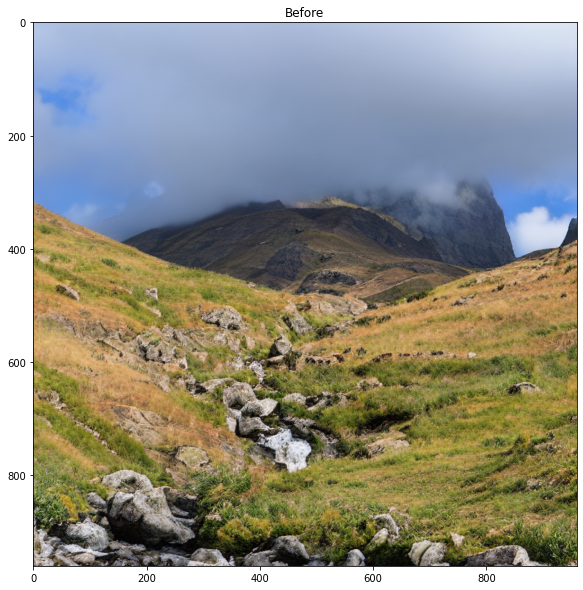

In [6]:
plt.figure(figsize = (10,10))
img = plt.imread("img/0.png")
plt.imshow(img)
plt.title("Before")

Text(0.5, 1.0, 'After')

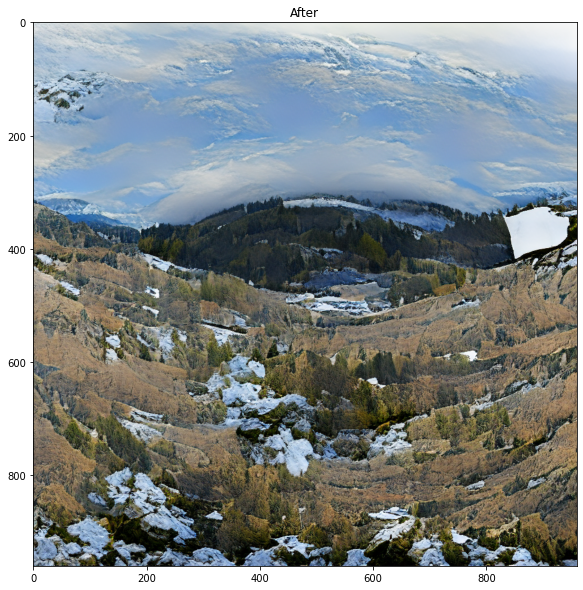

In [7]:
plt.figure(figsize = (10,10))
img = plt.imread(filepath)
plt.imshow(img)
plt.title("After")